In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/project-GCN/Graph_TimeSeries_Forecasting

/content/drive/MyDrive/project-GCN/Graph_TimeSeries_Forecasting


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [ ]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [ ]:
### READ DATA ###

df = pd.read_csv('sales_train.csv.zip')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = df.copy()
unstaked_df['id'] = df['item'].astype(str)+'_'+df['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

print(unstaked_df.shape)
unstaked_df.head()

(500, 1826)


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,2013-01-11,2013-01-12,2013-01-13,2013-01-14,2013-01-15,2013-01-16,2013-01-17,2013-01-18,2013-01-19,2013-01-20,2013-01-21,2013-01-22,2013-01-23,2013-01-24,2013-01-25,2013-01-26,2013-01-27,2013-01-28,2013-01-29,2013-01-30,2013-01-31,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,...,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_1,37.0,34.0,32.0,45.0,35.0,54.0,37.0,37.0,32.0,36.0,33.0,36.0,36.0,26.0,24.0,41.0,35.0,37.0,45.0,40.0,26.0,37.0,47.0,46.0,42.0,38.0,38.0,18.0,33.0,26.0,38.0,45.0,34.0,42.0,38.0,42.0,39.0,44.0,47.0,48.0,...,67.0,78.0,87.0,95.0,93.0,64.0,78.0,96.0,73.0,71.0,60.0,72.0,35.0,51.0,48.0,64.0,77.0,43.0,66.0,52.0,47.0,52.0,43.0,60.0,58.0,59.0,49.0,51.0,42.0,69.0,60.0,67.0,88.0,42.0,50.0,55.0,63.0,56.0,78.0,74.0
10_10,45.0,50.0,53.0,51.0,54.0,54.0,54.0,40.0,50.0,53.0,50.0,43.0,50.0,35.0,45.0,46.0,47.0,46.0,43.0,50.0,42.0,32.0,54.0,47.0,59.0,61.0,54.0,37.0,47.0,47.0,48.0,77.0,60.0,64.0,34.0,51.0,55.0,48.0,62.0,64.0,...,74.0,118.0,88.0,110.0,102.0,69.0,88.0,99.0,93.0,69.0,69.0,80.0,50.0,78.0,81.0,62.0,74.0,57.0,78.0,54.0,55.0,56.0,88.0,81.0,77.0,79.0,50.0,60.0,68.0,80.0,64.0,74.0,66.0,61.0,53.0,72.0,81.0,69.0,86.0,67.0
10_2,51.0,56.0,46.0,56.0,53.0,68.0,37.0,47.0,65.0,61.0,56.0,72.0,72.0,33.0,52.0,64.0,69.0,63.0,51.0,70.0,39.0,65.0,53.0,58.0,77.0,64.0,85.0,38.0,51.0,53.0,50.0,50.0,52.0,87.0,39.0,58.0,54.0,60.0,65.0,60.0,...,89.0,110.0,138.0,120.0,137.0,74.0,89.0,73.0,122.0,91.0,84.0,106.0,65.0,82.0,67.0,89.0,94.0,96.0,90.0,72.0,56.0,87.0,73.0,81.0,109.0,100.0,52.0,68.0,65.0,88.0,86.0,114.0,84.0,66.0,69.0,63.0,78.0,76.0,77.0,116.0
10_3,38.0,60.0,50.0,46.0,46.0,52.0,40.0,41.0,32.0,38.0,52.0,46.0,53.0,33.0,36.0,42.0,41.0,42.0,48.0,61.0,40.0,42.0,42.0,50.0,43.0,60.0,57.0,29.0,47.0,42.0,47.0,56.0,41.0,55.0,34.0,37.0,46.0,47.0,48.0,49.0,...,97.0,98.0,96.0,108.0,123.0,91.0,98.0,113.0,100.0,81.0,85.0,86.0,47.0,56.0,67.0,76.0,78.0,71.0,76.0,61.0,72.0,60.0,73.0,90.0,100.0,72.0,62.0,69.0,56.0,80.0,83.0,71.0,101.0,45.0,61.0,51.0,56.0,61.0,72.0,68.0
10_4,30.0,29.0,37.0,45.0,52.0,58.0,29.0,44.0,53.0,39.0,39.0,46.0,50.0,33.0,43.0,39.0,37.0,42.0,42.0,62.0,38.0,39.0,31.0,49.0,37.0,49.0,42.0,57.0,34.0,34.0,55.0,52.0,48.0,57.0,30.0,45.0,36.0,56.0,51.0,42.0,...,82.0,92.0,69.0,108.0,118.0,74.0,100.0,95.0,93.0,55.0,74.0,75.0,49.0,48.0,71.0,74.0,68.0,64.0,81.0,57.0,63.0,80.0,73.0,64.0,80.0,93.0,66.0,62.0,61.0,79.0,75.0,64.0,86.0,56.0,54.0,57.0,53.0,65.0,74.0,69.0


In [ ]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14



def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, 10, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 10))

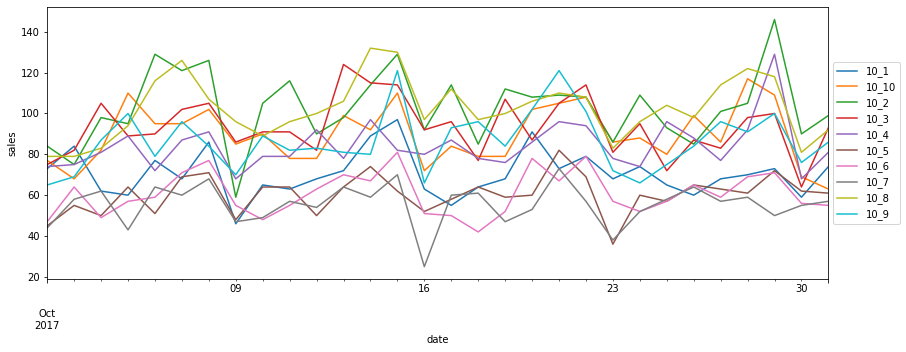

In [ ]:
### PLOT A SEQUENCE OF SALES FOR ITEM 10 IN ALL STORES ###

sequence = get_timespan(unstaked_df, date(2017,11,1), 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2013, 1, 1)
valid_date = date(2015, 1, 1)
test_date = date(2016, 1, 1)

In [ ]:
### CREATE TRAIN FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|██████████| 717/717 [01:01<00:00, 11.64it/s]


(35850, 14, 10) (35850, 10, 10) (35850, 10, 7) (35850, 10)


In [ ]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


(17600, 14, 10) (17600, 10, 10) (17600, 10, 7) (17600, 10)


In [ ]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2016,12,31))):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 352/352 [00:29<00:00, 11.85it/s]


(17600, 14, 10) (17600, 10, 10) (17600, 10, 7) (17600, 10)


In [ ]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

In [ ]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    
    set_seed(33)

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, 10))
    inp_lap = Input((10, 10))
    inp_feat = Input((10, X_train_feat.shape[-1]))

    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
model = get_model()
model.summary() 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
graph_conv_22 (GraphConv)       (None, 10, 32)       256         input_36[0][0]                   
                                                                 input_35[0][0]                   
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 14, 10)]     0                                     

In [ ]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(10):

    print('-------', 'store', store, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,store], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:,store]), callbacks=[es], verbose=2)

    pred_valid_all[:,store] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,store] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
141/141 - 16s - loss: 0.3336 - root_mean_squared_error: 0.5776 - val_loss: 0.7759 - val_root_mean_squared_error: 0.8809
Epoch 2/100
141/141 - 12s - loss: 0.2514 - root_mean_squared_error: 0.5014 - val_loss: 0.7105 - val_root_mean_squared_error: 0.8429
Epoch 3/100
141/141 - 12s - loss: 0.2384 - root_mean_squared_error: 0.4883 - val_loss: 0.6402 - val_root_mean_squared_error: 0.8001
Epoch 4/100
141/141 - 12s - loss: 0.2258 - root_mean_squared_error: 0.4752 - val_loss: 0.5989 - val_root_mean_squared_error: 0.7739
Epoch 5/100
141/141 - 13s - loss: 0.1942 - root_mean_squared_error: 0.4407 - val_loss: 1.4175 - val_root_mean_squared_error: 1.1906
Epoch 6/100
141/141 - 13s - loss: 0.1886 - root_mean_squared_error: 0.4343 - val_loss: 0.7283 - val_root_mean_squared_error: 0.8534
Epoch 7/100
141/141 - 13s - loss: 0.1740 - root_mean_squared_error: 0.4171 - val_loss: 0.6840 - val_root_mean_squared_error: 0.8270
Epoch 8/100
141/141 - 13s - loss: 0.1680 - root_mean_squared_error: 0.4099 -

In [ ]:
### RMSE ON TEST DATA ###

error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

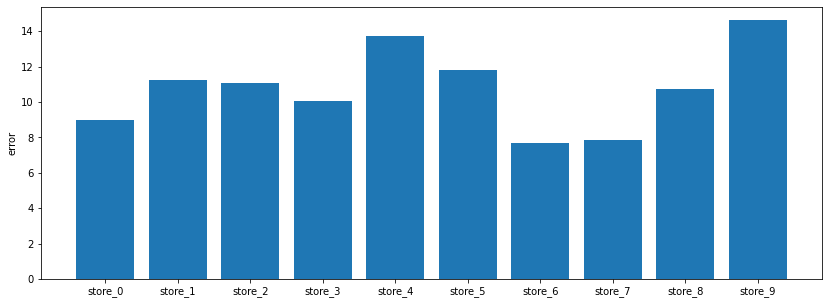

In [ ]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

In [ ]:
### UTILITY FUNCTION TO PLOT PREDICTION ###

def plot_predictions(y_true, y_pred, store, item):
    
    y_true = y_true.reshape(50,-1,10)
    y_pred = y_pred.reshape(50,-1,10)
    
    plt.plot(y_true[item,:,store], label='true')
    plt.plot(y_pred[item,:,store], label='prediction')
    plt.title(f"store: {store} item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')

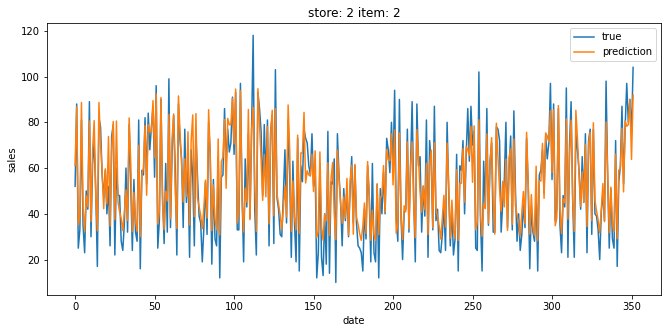

In [ ]:
plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all,2,2)